### Import required platforms, libraries, and frameworks.

In [4]:
!pip install keras_preprocessing==1.0.6

import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import cv2
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import glob
from keras.models import Model
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout, Flatten, Dense

### Mount drive containing dataset.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Generate plots to visualize data imbalances.

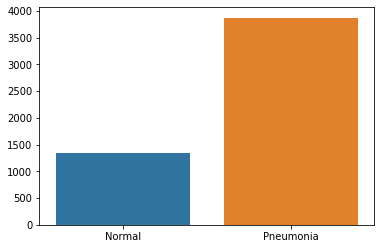

In [6]:
trainLabels = "/content/drive/MyDrive/chest_xray/train/"
testLabels = "/content/drive/MyDrive/chest_xray/test/"
valLabels = "/content/drive/MyDrive/chest_xray/val/"

trainNormal = glob.glob(trainLabels+"NORMAL/*.jpeg")
trainPneumonia = glob.glob(trainLabels+"PNEUMONIA/*.jpeg")
valNormal = glob.glob(valLabels+"NORMAL/*.jpeg")
valPneumonia = glob.glob(valLabels+"PNEUMONIA/*.jpeg")
testNormal = glob.glob(testLabels+"NORMAL/*.jpeg")
testPneumonia = glob.glob(testLabels+"PNEUMONIA/*.jpeg")

sns.barplot(x=["Normal","Pneumonia"],y=[len(trainNormal),len(trainPneumonia)])

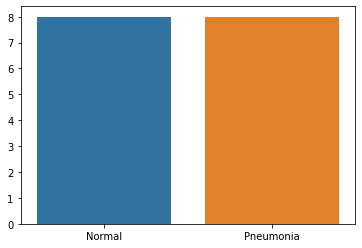

In [7]:
sns.barplot(x=["Normal","Pneumonia"],y=[len(valNormal),len(valPneumonia)])

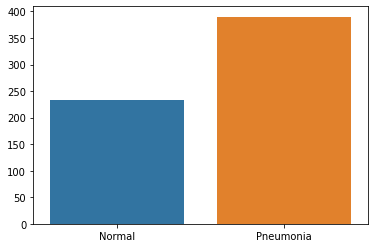

In [8]:
sns.barplot(x=["Normal","Pneumonia"],y=[len(testNormal),len(testPneumonia)])

### Get counts of Normal/Pneumonia images in training, validation, and testing sets.

In [9]:
print('Pneumonia x-ray images in training set = ', len(trainPneumonia))
print('Normal x-ray images in training set = ', len(trainNormal))
print('Pneumonia x-ray images in validation set = ', len(valPneumonia))
print('Normal x-ray images in validation set = ', len(valNormal))
print('Pneumonia x-ray images in test set = ', len(testPneumonia))
print('Normal x-ray images in test set = ', len(testNormal))

Pneumonia x-ray images in training set =  3875
Normal x-ray images in training set =  1341
Pneumonia x-ray images in validation set =  8
Normal x-ray images in validation set =  8
Pneumonia x-ray images in test set =  390
Normal x-ray images in test set =  234


### Visualize the images from both classes of the training dataset.

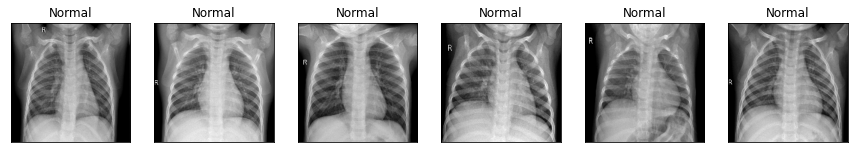

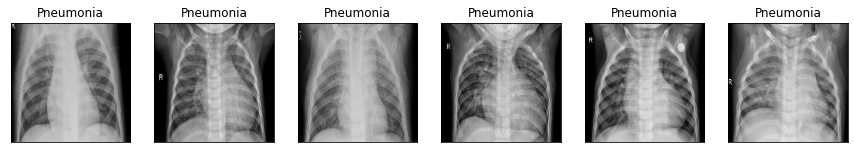

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(trainNormal[i])
    img = cv2.resize(img, (200,200))
    ax.imshow(img)
    ax.set_title("Normal")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(trainPneumonia[i])
    img = cv2.resize(img, (200,200))
    ax.imshow(img)
    ax.set_title("Pneumonia")
plt.show()

### Initialize image data generators to preprocess and scale images to tensors and feed tensors as input to both models of residual neural networks.

In [11]:
training = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input)
validation = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input)
testing = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input)

### Create training, validation, and testing datasets of tensors.

In [102]:
training_dataset = training.flow_from_directory(trainLabels,
                                            target_size = (224,224), 
                                            batch_size = 32,
                                            class_mode = 'binary')

validation_dataset = validation.flow_from_directory(valLabels,
                                            target_size = (224,224), 
                                            batch_size = 32,
                                            class_mode = 'binary')

testing_dataset = testing.flow_from_directory(testLabels,
                                            target_size = (224,224), 
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### View the corresponding indices for classification labels.

In [103]:
training_dataset.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

### View classification labels

In [104]:
training_dataset.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

### Initialize and compile ResNet-18 model with randomly initialized weights and parameters by obtaining the 18th layer of the ResNet-50 base model.

In [108]:
baseModel = tf.keras.applications.resnet50.ResNet50(weights = None, include_top = False, input_shape = (224,224,3), pooling = 'avg', classes = 2)

lastLayer = baseModel.get_layer('conv3_block3_1_relu')
baseModelOutput = lastLayer.output

X = tf.keras.layers.Flatten()(baseModelOutput)
X = tf.keras.layers.Dropout(0.5)(X) 
X = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
ResNet18 = tf.keras.Model(baseModel.input, X)

ResNet18.compile(loss = 'binary_crossentropy', 
             optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])

ResNet18.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_16[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Fit the ResNet-18 model with randomly initialized weights and parameters and include necessary callbacks to combat overfitting.

In [109]:
callback1 = ReduceLROnPlateau(monitor = 'val_loss', patience = 4, cooldown = 0, verbose = 1, factor = 0.6, min_lr = 0.0000001)
callback2 = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 8, restore_best_weights = False)
history = ResNet18.fit(training_dataset, validation_data = validation_dataset, epochs = 60, callbacks = [callback1, callback2])

Epoch 1/60
163/163 [==============================] - 82s 483ms/step - loss: 0.1753 - accuracy: 0.9306 - val_loss: 2.2935 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/60
163/163 [==============================] - 78s 476ms/step - loss: 0.0733 - accuracy: 0.9699 - val_loss: 1.0483 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/60
163/163 [==============================] - 78s 477ms/step - loss: 0.0432 - accuracy: 0.9814 - val_loss: 0.0898 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/60
163/163 [==============================] - 78s 478ms/step - loss: 0.0275 - accuracy: 0.9895 - val_loss: 0.1392 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 5/60
163/163 [==============================] - 78s 476ms/step - loss: 0.0171 - accuracy: 0.9944 - val_loss: 0.3576 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 6/60
163/163 [==============================] - 78s 477ms/step - loss: 0.0105 - accuracy: 0.9973 - val_loss: 0.2731 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 7/60
163/163 [========

### Display accuracy and loss curves for ResNet-18 model with randomly initialized weights and parameters.

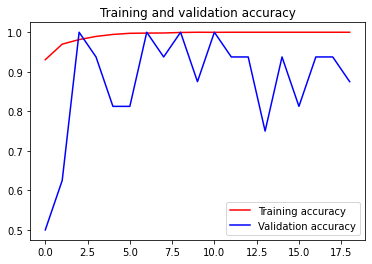

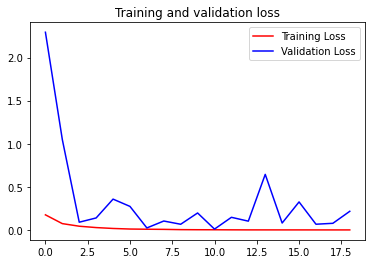

In [111]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Using the ResNet-18 model with randomly initialized weights and parameters, predict class labels of each testing directory. Store misclassified images in array to be used as examples for gradient class activation map at the end of the notebook. Display first 20 failure cases (i.e. misclassified images) from each directory. Display accuracy for test set.

X-Ray file NORMAL2-IM-0251-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0059-0001.jpeg correctly classified as Normal
X-Ray file IM-0005-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0107-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 1 out of all 234 Normal X-Ray files


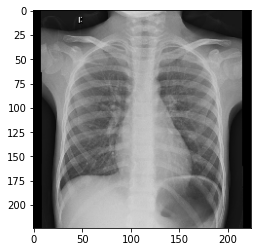

X-Ray file IM-0097-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 2 out of all 234 Normal X-Ray files


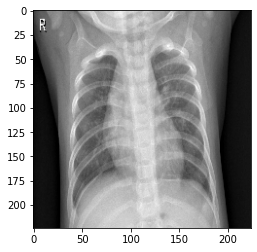

X-Ray file IM-0063-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0310-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0327-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0246-0001-0002.jpeg correctly classified as Normal
X-Ray file IM-0015-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0030-0001.jpeg correctly classified as Normal
X-Ray file IM-0033-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0066-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 3 out of all 234 Normal X-Ray files


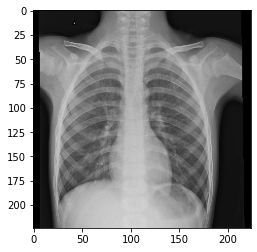

X-Ray file NORMAL2-IM-0272-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 4 out of all 234 Normal X-Ray files


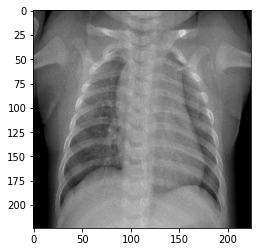

X-Ray file NORMAL2-IM-0316-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0252-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0312-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0297-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 5 out of all 234 Normal X-Ray files


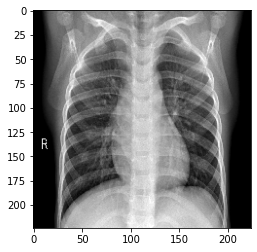

X-Ray file IM-0107-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 6 out of all 234 Normal X-Ray files


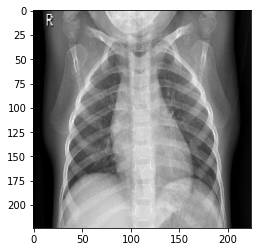

X-Ray file IM-0007-0001.jpeg correctly classified as Normal
X-Ray file IM-0077-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0280-0001.jpeg correctly classified as Normal
X-Ray file IM-0073-0001.jpeg correctly classified as Normal
X-Ray file IM-0085-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0092-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0354-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0381-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0275-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0213-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0277-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 7 out of all 234 Normal X-Ray files


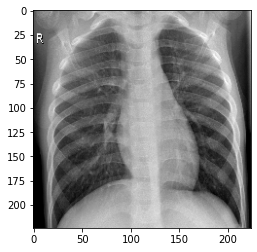

X-Ray file IM-0010-0001.jpeg correctly classified as Normal
X-Ray file IM-0013-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0304-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 8 out of all 234 Normal X-Ray files


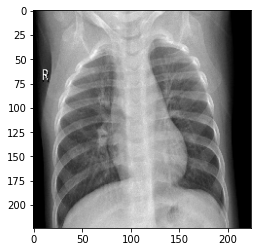

X-Ray file NORMAL2-IM-0081-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 9 out of all 234 Normal X-Ray files


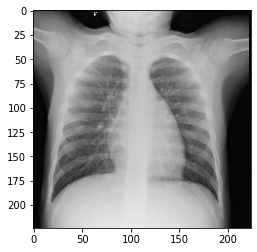

X-Ray file NORMAL2-IM-0374-0001-0001.jpeg correctly classified as Normal
X-Ray file IM-0111-0001.jpeg correctly classified as Normal
X-Ray file IM-0039-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0300-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0370-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 10 out of all 234 Normal X-Ray files


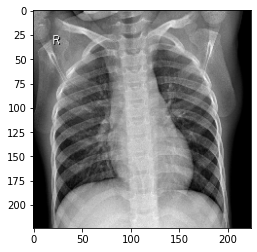

X-Ray file NORMAL2-IM-0013-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0353-0001.jpeg correctly classified as Normal
X-Ray file IM-0079-0001.jpeg correctly classified as Normal
X-Ray file IM-0037-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0073-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0150-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0052-0001.jpeg correctly classified as Normal
X-Ray file IM-0069-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 11 out of all 234 Normal X-Ray files


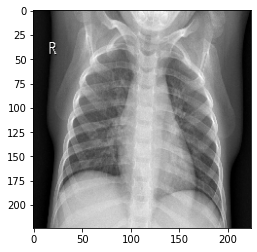

X-Ray file NORMAL2-IM-0319-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0346-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 12 out of all 234 Normal X-Ray files


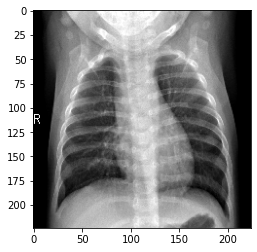

X-Ray file NORMAL2-IM-0232-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0171-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0276-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0206-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0326-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 13 out of all 234 Normal X-Ray files


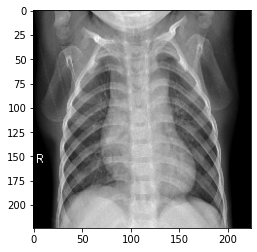

X-Ray file NORMAL2-IM-0311-0001.jpeg correctly classified as Normal
X-Ray file IM-0011-0001-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0333-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0196-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0198-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0289-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 14 out of all 234 Normal X-Ray files


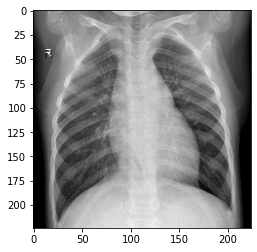

X-Ray file NORMAL2-IM-0369-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 15 out of all 234 Normal X-Ray files


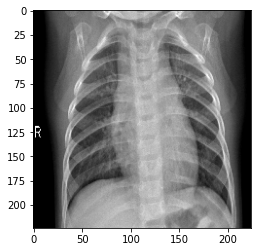

X-Ray file NORMAL2-IM-0246-0001-0001.jpeg correctly classified as Normal
X-Ray file IM-0011-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0120-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0374-0001-0002.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 16 out of all 234 Normal X-Ray files


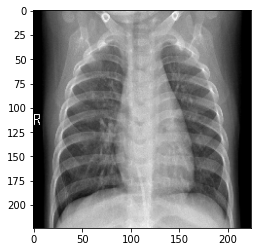

X-Ray file NORMAL2-IM-0259-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0281-0001.jpeg correctly classified as Normal
X-Ray file IM-0021-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0007-0001.jpeg correctly classified as Normal
X-Ray file IM-0049-0001.jpeg correctly classified as Normal
X-Ray file IM-0050-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0352-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0339-0001.jpeg correctly classified as Normal
X-Ray file IM-0070-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 17 out of all 234 Normal X-Ray files


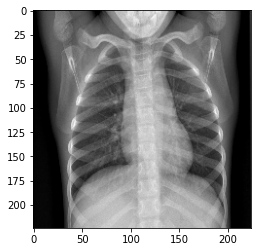

X-Ray file NORMAL2-IM-0110-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0195-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0123-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 18 out of all 234 Normal X-Ray files


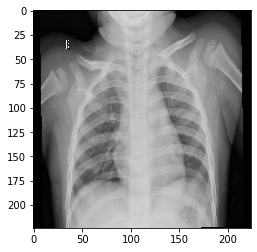

X-Ray file NORMAL2-IM-0135-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0233-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 19 out of all 234 Normal X-Ray files


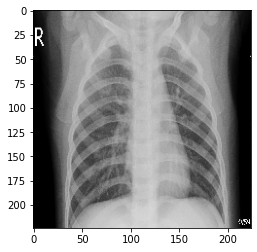

X-Ray file NORMAL2-IM-0285-0001.jpeg correctly classified as Normal
X-Ray file IM-0081-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 20 out of all 234 Normal X-Ray files


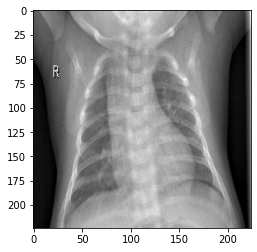

X-Ray file NORMAL2-IM-0359-0001.jpeg correctly classified as Normal
X-Ray file IM-0003-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0336-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0331-0001.jpeg correctly classified as Normal
X-Ray file IM-0109-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 21 out of all 234 Normal X-Ray files
X-Ray file NORMAL2-IM-0307-0001.jpeg correctly classified as Normal
X-Ray file IM-0099-0001.jpeg correctly classified as Normal
X-Ray file NORMAL2-IM-0364-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 22 out of all 234 Normal X-Ray files
X-Ray file IM-0101-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 23 out of all 234 Normal X-Ray files
X-Ray file NORMAL2-IM-0141-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 24 out of all 234 Normal X-Ray files
X-Ray file NORMAL2-IM-0096-0001.

In [185]:
import numpy as np
dir_path = '/content/drive/MyDrive/chest_xray/test/NORMAL'
arr = os.listdir(dir_path)
misclassifiedImgs = []
random.shuffle(arr)
count1 = 0
displayLimit = 20
for i in arr:
    img = image.load_img(dir_path+'/'+i, target_size = (224,224))
    X = image.img_to_array(img)
    X = np.expand_dims(X,axis = 0)
    images = np.vstack([X])   
    val = (ResNet18.predict(images) > 0.5).astype("int32")     
    if val == 1:
        print("X-Ray file "+ i + " correctly classified as Normal")
    else:
        count1+=1
        print("X-Ray file", i, "Misclassified as an X-Ray file with Pneumonia. This is misclassified file", count1, "out of all", len(testNormal), "Normal X-Ray files")
        misclassifiedImgs.append(dir_path+'/'+i)
        if(count1 <= displayLimit):
            plt.imshow(img)
            plt.show()
        
nAccuracy = 1 - (count1 / len(testNormal))
print("Accuracy for Normal X-Ray files in testing set: ", nAccuracy)

X-Ray file person100_bacteria_482.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person126_bacteria_600.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person109_bacteria_513.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person175_bacteria_833.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person127_bacteria_602.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person78_virus_140.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person147_bacteria_705.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person127_bacteria_603.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person101_bacteria_483.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1651_virus_2855.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person117_bacteria_553.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ra

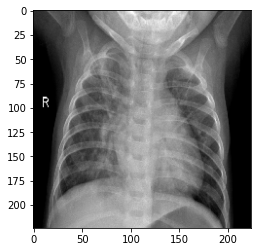

X-Ray file person82_bacteria_403.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1670_virus_2886.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person86_bacteria_428.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 2 out of all 390 X-Ray files with Pneumonia


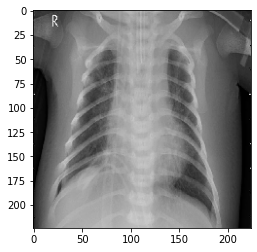

X-Ray file person157_bacteria_740.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person96_bacteria_465.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person153_bacteria_726.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 3 out of all 390 X-Ray files with Pneumonia


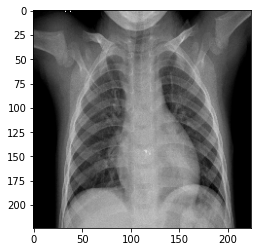

X-Ray file person56_virus_112.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1_virus_7.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person85_bacteria_417.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person142_bacteria_683.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person126_bacteria_598.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person128_bacteria_608.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person130_bacteria_623.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person24_virus_58.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person143_bacteria_687.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1647_virus_2848.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 4 out of all 390 X-Ray files with Pneumonia


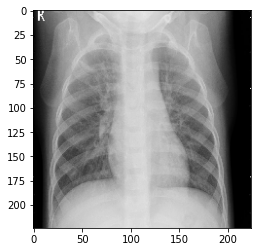

X-Ray file person1667_virus_2881.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 5 out of all 390 X-Ray files with Pneumonia


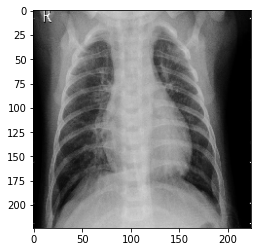

X-Ray file person174_bacteria_832.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1662_virus_2875.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 6 out of all 390 X-Ray files with Pneumonia


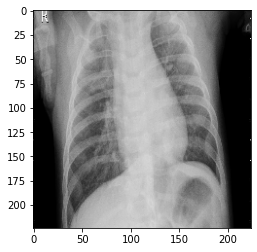

X-Ray file person133_bacteria_633.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person137_bacteria_655.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person83_bacteria_412.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person3_virus_15.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person71_virus_132.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person51_virus_105.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person125_bacteria_594.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person121_bacteria_575.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person114_bacteria_546.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1650_virus_2852.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person44_virus_93.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person134

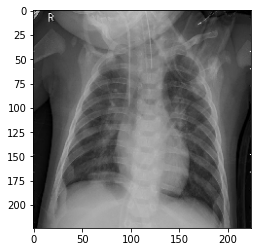

X-Ray file person78_bacteria_387.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 8 out of all 390 X-Ray files with Pneumonia


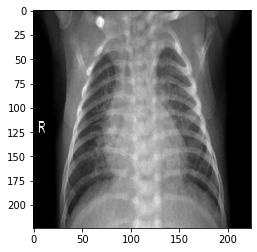

X-Ray file person53_virus_107.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person66_virus_125.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person96_bacteria_464.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person77_virus_139.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 9 out of all 390 X-Ray files with Pneumonia


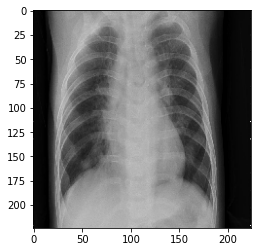

X-Ray file person29_virus_64.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person38_virus_84.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person60_virus_117.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person15_virus_46.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person139_bacteria_666.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person91_bacteria_447.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person96_bacteria_466.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person101_bacteria_484.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person151_bacteria_718.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 10 out of all 390 X-Ray files with Pneumonia


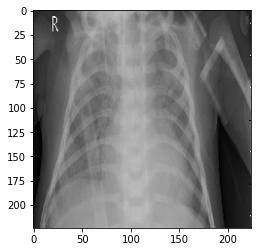

X-Ray file person134_bacteria_640.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person88_bacteria_437.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person39_virus_85.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person134_bacteria_641.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person123_bacteria_587.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person99_bacteria_474.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person99_bacteria_473.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person127_bacteria_604.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 11 out of all 390 X-Ray files with Pneumonia


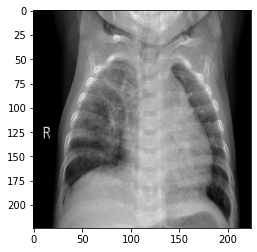

X-Ray file person119_bacteria_566.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person111_bacteria_533.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person85_bacteria_422.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person120_bacteria_571.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person146_bacteria_700.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person11_virus_38.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person150_bacteria_717.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 12 out of all 390 X-Ray files with Pneumonia


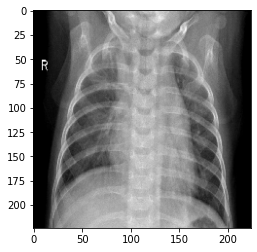

X-Ray file person14_virus_44.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person122_bacteria_584.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person83_bacteria_409.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person121_bacteria_580.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person80_bacteria_390.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person26_virus_60.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person138_bacteria_659.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person20_virus_51.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person37_virus_82.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1631_virus_2826.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person91_bacteria_445.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person86_bac

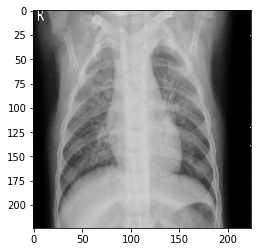

X-Ray file person34_virus_76.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person158_bacteria_743.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person118_bacteria_559.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person72_virus_133.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person109_bacteria_523.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person154_bacteria_728.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person108_bacteria_506.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person125_bacteria_595.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person100_bacteria_481.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person8_virus_28.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 14 out of all 390 X-Ray files with Pneumonia


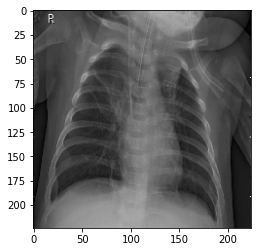

X-Ray file person53_virus_108.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 15 out of all 390 X-Ray files with Pneumonia


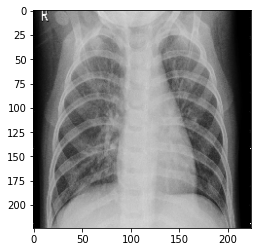

X-Ray file person122_bacteria_581.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 16 out of all 390 X-Ray files with Pneumonia


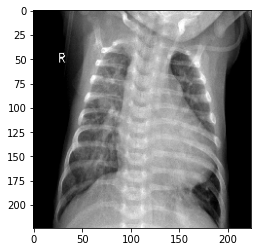

X-Ray file person1685_virus_2903.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person140_bacteria_668.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person108_bacteria_511.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person42_virus_89.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person85_bacteria_423.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person141_bacteria_676.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person118_bacteria_560.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1659_virus_2867.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 17 out of all 390 X-Ray files with Pneumonia


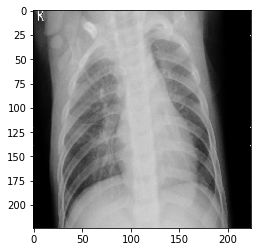

X-Ray file person141_bacteria_681.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1671_virus_2887.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person104_bacteria_491.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person80_bacteria_389.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1640_virus_2839.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person124_bacteria_589.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person109_bacteria_528.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person158_bacteria_742.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person83_bacteria_414.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1669_virus_2884.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person114_bacteria_545.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ra

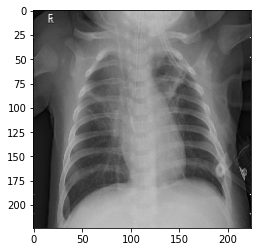

X-Ray file person159_bacteria_747.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person136_bacteria_652.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person102_bacteria_487.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person122_bacteria_583.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person92_bacteria_451.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person88_bacteria_439.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 19 out of all 390 X-Ray files with Pneumonia


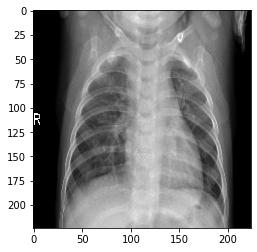

X-Ray file person108_bacteria_504.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person45_virus_95.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person136_bacteria_648.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person48_virus_100.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person141_bacteria_670.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person40_virus_87.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1634_virus_2830.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person120_bacteria_572.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person119_bacteria_565.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person82_bacteria_405.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person132_bacteria_632.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file pers

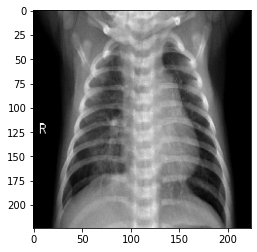

X-Ray file person128_bacteria_606.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person18_virus_49.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person111_bacteria_535.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person91_bacteria_448.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person22_virus_55.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1_virus_6.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person173_bacteria_830.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person109_bacteria_527.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person17_virus_48.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person62_virus_119.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person81_bacteria_398.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person144_bacter

In [186]:
dir_path = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA'
arr = os.listdir(dir_path)
random.shuffle(arr)
count2 = 0
for i in arr:
    img = image.load_img(dir_path+'/'+i, target_size = (224,224))
    X = image.img_to_array(img)
    X = np.expand_dims(X,axis = 0)
    images = np.vstack([X])
    val = (ResNet18.predict(images) > 0.5).astype("int32")     

    if val == 1:
        print("X-Ray file "+ i + " correctly classified as a X-Ray file with Pneumonia")
    else:
        count2+=1
        print("X-Ray file", i, "Misclassified as a Normal X-Ray file. This is misclassified file", count2, "out of all", len(testPneumonia), "X-Ray files with Pneumonia")
        misclassifiedImgs.append(dir_path+'/'+i)
        if(count2 <= displayLimit):
            plt.imshow(img)
            plt.show()
        
pAccuracy = 1 - (count2 / len(testPneumonia))
print("Accuracy for X-Ray files with Pneumonia in testing set: ", pAccuracy)

In [183]:
print("accuracy for test set: ", (nAccuracy + pAccuracy) / 2 )

accuracy for test set:  0.8111111111111111


### Evaluate the ResNet-18 model with randomly initialized weights and parameters on the testing dataset.

In [184]:
ResNet18.evaluate(testing_dataset)

20/20 [==============================] - 8s 401ms/step - loss: 2.0209 - accuracy: 0.7308


[2.0208852291107178, 0.7307692170143127]

### Initialize and compile ResNet-18 model with ImageNet initialized weights and parameters by obtaining the 18th layer of the ResNet-50 base model.

In [153]:
baseModel2 = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

for layers in baseModel2.layers:
    layers.trainable = False

model_builder = baseModel2
preprocess_input = tf.keras.applications.resnet50.preprocess_input
decode_predictions = tf.keras.applications.resnet50.decode_predictions


lastLayer = baseModel2.get_layer('conv3_block3_1_relu') 
baseModel2Output = lastLayer.output

X = tf.keras.layers.Flatten()(baseModel2Output)
X = tf.keras.layers.Dropout(0.5)(X)
X = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
ResNet18Img = tf.keras.Model(baseModel2.input, X)

ResNet18Img.compile(loss = 'binary_crossentropy', 
             optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
             metrics = ['accuracy']) 
ResNet18Img.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_21[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Fit the ResNet-18 model with ImageNet initialized weights and parameters and include necessary callbacks to combat overfitting.





In [154]:
callback1 = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, cooldown = 0, verbose = 1, factor = 0.6, min_lr = 0.0000001)
callback2 = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
historyimagenet = ResNet18Img.fit(training_dataset, validation_data = validation_dataset, epochs = 60, callbacks = [callback1, callback2])

Epoch 1/60
163/163 [==============================] - 81s 490ms/step - loss: 0.4160 - accuracy: 0.9160 - val_loss: 0.2417 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/60
163/163 [==============================] - 79s 486ms/step - loss: 0.0493 - accuracy: 0.9822 - val_loss: 0.1973 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/60
163/163 [==============================] - 75s 459ms/step - loss: 0.0155 - accuracy: 0.9950 - val_loss: 0.0281 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/60
163/163 [==============================] - 74s 455ms/step - loss: 0.0148 - accuracy: 0.9958 - val_loss: 0.0365 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/60
163/163 [==============================] - 74s 456ms/step - loss: 0.0100 - accuracy: 0.9964 - val_loss: 0.0196 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/60
163/163 [==============================] - 75s 462ms/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.0233 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/60
163/163 [==============================] 

### Display accuracy and loss curves for ResNet-18 model with ImageNet initialized weights and parameters.

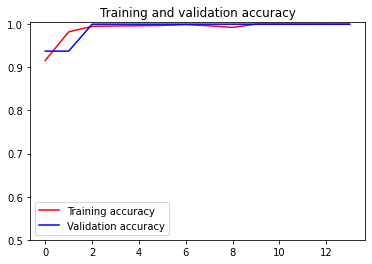

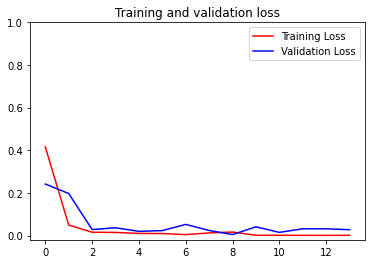

In [155]:
acc = historyimagenet.history['accuracy']
val_acc = historyimagenet.history['val_accuracy']

loss = historyimagenet.history['loss']
val_loss = historyimagenet.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Using the ResNet-18 model with ImageNet initialized weights and parameters, predict class labels of each testing directory. Store misclassified images in array to be used as examples for gradient class activation map at the end of the notebook. Display first 20 failure cases (i.e. misclassified images) from each directory. Display accuracy for test set.

X-Ray File IM-0021-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0028-0001.jpeg is Normal
X-Ray File IM-0015-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0256-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0267-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0380-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 1 out of all 234 Normal X-Ray files


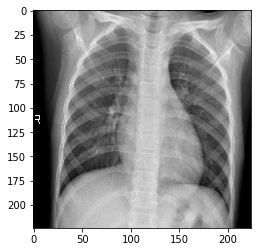

X-Ray File NORMAL2-IM-0246-0001-0001.jpeg is Normal
X-Ray file IM-0050-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 2 out of all 234 Normal X-Ray files


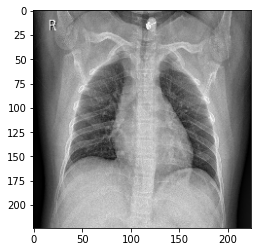

X-Ray File IM-0023-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0370-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0033-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 3 out of all 234 Normal X-Ray files


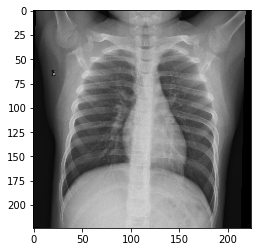

X-Ray File IM-0085-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0297-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0066-0001.jpeg is Normal
X-Ray File IM-0031-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0145-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0302-0001.jpeg is Normal
X-Ray File IM-0001-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0326-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 4 out of all 234 Normal X-Ray files


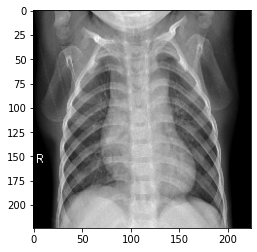

X-Ray File NORMAL2-IM-0251-0001.jpeg is Normal
X-Ray File IM-0003-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0123-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0301-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 5 out of all 234 Normal X-Ray files


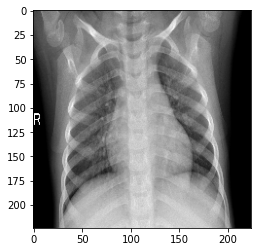

X-Ray File NORMAL2-IM-0315-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0372-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 6 out of all 234 Normal X-Ray files


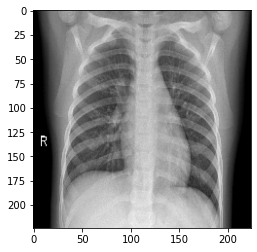

X-Ray file NORMAL2-IM-0351-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 7 out of all 234 Normal X-Ray files


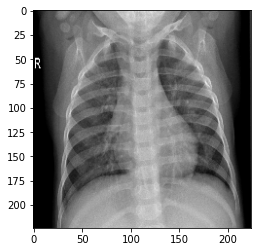

X-Ray file NORMAL2-IM-0343-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 8 out of all 234 Normal X-Ray files


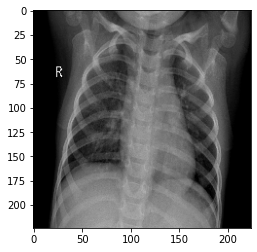

X-Ray file NORMAL2-IM-0346-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 9 out of all 234 Normal X-Ray files


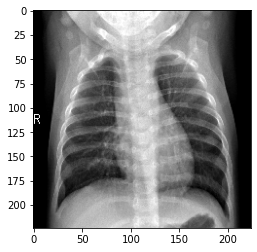

X-Ray File IM-0071-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0311-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0271-0001.jpeg is Normal
X-Ray File IM-0011-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0171-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0237-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0222-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0310-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 10 out of all 234 Normal X-Ray files


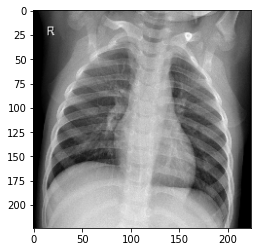

X-Ray File NORMAL2-IM-0249-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0098-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0027-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 11 out of all 234 Normal X-Ray files


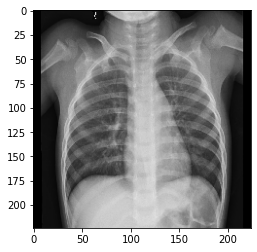

X-Ray file NORMAL2-IM-0129-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 12 out of all 234 Normal X-Ray files


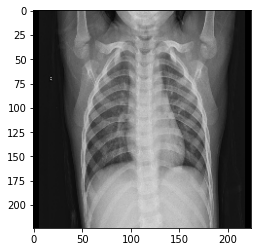

X-Ray File IM-0011-0001-0001.jpeg is Normal
X-Ray File IM-0022-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0345-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 13 out of all 234 Normal X-Ray files


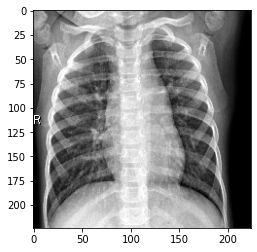

X-Ray File NORMAL2-IM-0349-0001.jpeg is Normal
X-Ray File IM-0101-0001.jpeg is Normal
X-Ray file IM-0067-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 14 out of all 234 Normal X-Ray files


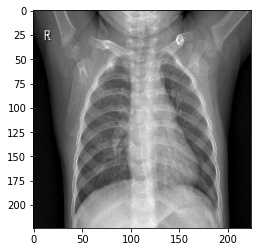

X-Ray File NORMAL2-IM-0213-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0362-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 15 out of all 234 Normal X-Ray files


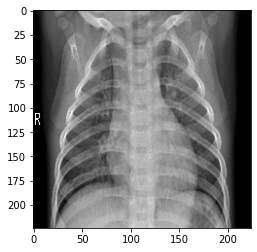

X-Ray File NORMAL2-IM-0199-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0278-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 16 out of all 234 Normal X-Ray files


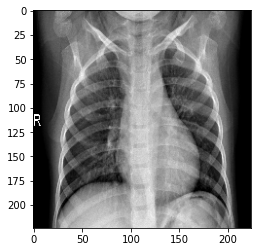

X-Ray File NORMAL2-IM-0221-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0337-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 17 out of all 234 Normal X-Ray files


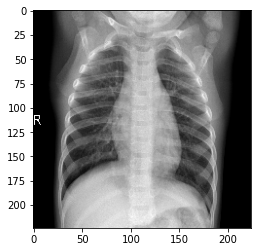

X-Ray File IM-0093-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0283-0001.jpeg is Normal
X-Ray file IM-0041-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 18 out of all 234 Normal X-Ray files


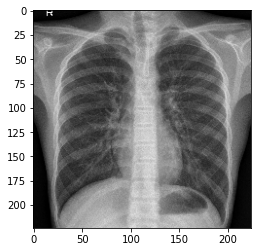

X-Ray File IM-0043-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0102-0001.jpeg is Normal
X-Ray File IM-0033-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0219-0001.jpeg is Normal
X-Ray File NORMAL2-IM-0280-0001.jpeg is Normal
X-Ray File IM-0077-0001.jpeg is Normal
X-Ray file IM-0099-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 19 out of all 234 Normal X-Ray files


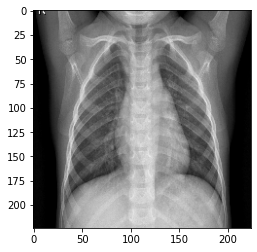

X-Ray File NORMAL2-IM-0282-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0328-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 20 out of all 234 Normal X-Ray files


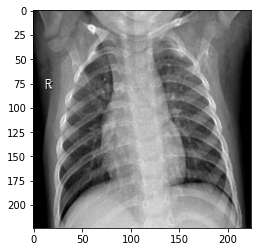

X-Ray file IM-0030-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 21 out of all 234 Normal X-Ray files
X-Ray file IM-0081-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 22 out of all 234 Normal X-Ray files
X-Ray file IM-0049-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 23 out of all 234 Normal X-Ray files
X-Ray File NORMAL2-IM-0336-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0288-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 24 out of all 234 Normal X-Ray files
X-Ray File NORMAL2-IM-0281-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0060-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 25 out of all 234 Normal X-Ray files
X-Ray File NORMAL2-IM-0338-0001.jpeg is Normal
X-Ray file NORMAL2-IM-0141-0001.jpeg Misclassified as an X-Ray file with Pneumonia. This is misclassified file 26 out of all 234 Normal X-Ray f

In [187]:
dir_path = '/content/drive/MyDrive/chest_xray/test/NORMAL'
arr = os.listdir(dir_path)
random.shuffle(arr)
count3 = 0
for i in arr:
    img = image.load_img(dir_path+'/'+i, target_size = (224,224))
    X = image.img_to_array(img)
    X = np.expand_dims(X,axis = 0)
    images = np.vstack([X])
   
    val = (ResNet18Img.predict(images) > 0.5).astype("int32")

    if val == 1:
        print("X-Ray File "+ i + " is Normal")
    else:
        count3+=1
        print("X-Ray file", i, "Misclassified as an X-Ray file with Pneumonia. This is misclassified file", count3, "out of all", len(testNormal), "Normal X-Ray files")
        misclassifiedImgs.append(dir_path+'/'+i)

        if(count3 <= displayLimit):
            plt.imshow(img)
            plt.show()
        
imgNormalAccuracy = 1 - (count3 / len(testNormal))
print("Accuracy for Normal X-Ray files in testing set: ", imgNormalAccuracy)

X-Ray file person99_bacteria_474.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1661_virus_2873.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person155_bacteria_730.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person142_bacteria_683.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1653_virus_2859.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person155_bacteria_729.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person122_bacteria_583.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person101_bacteria_486.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person40_virus_87.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1663_virus_2876.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person134_bacteria_641.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray fi

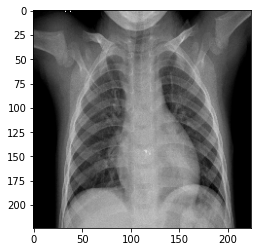

X-Ray file person128_bacteria_605.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person85_bacteria_419.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person88_bacteria_439.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 2 out of all 390 X-Ray files with Pneumonia


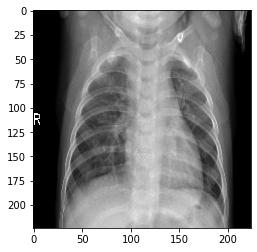

X-Ray file person100_bacteria_481.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person88_bacteria_437.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person57_virus_113.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1612_virus_2798.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1671_virus_2887.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person142_bacteria_682.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person85_bacteria_422.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person173_bacteria_830.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1_virus_8.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1668_virus_2882.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person139_bacteria_663.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file pers

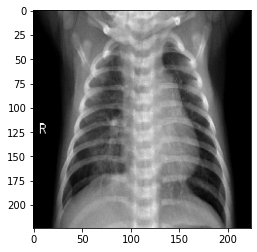

X-Ray file person103_bacteria_488.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person126_bacteria_599.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person20_virus_51.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person130_bacteria_628.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person152_bacteria_722.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1627_virus_2819.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person122_bacteria_584.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person126_bacteria_598.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person152_bacteria_724.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1673_virus_2889.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person101_bacteria_484.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray 

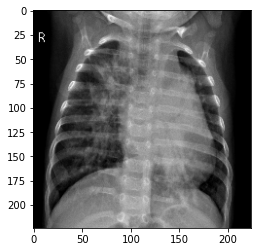

X-Ray file person90_bacteria_443.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person10_virus_35.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person118_bacteria_559.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person125_bacteria_595.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person80_bacteria_389.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1647_virus_2848.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person109_bacteria_526.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person161_bacteria_757.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1615_virus_2801.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person144_bacteria_690.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person157_bacteria_735.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray fi

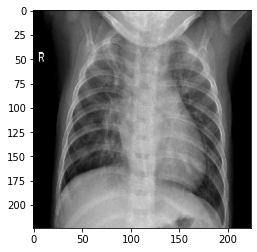

X-Ray file person80_bacteria_390.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person121_bacteria_576.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person22_virus_55.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person53_virus_107.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person71_virus_131.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person153_bacteria_725.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person26_virus_60.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1618_virus_2805.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person135_bacteria_646.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person85_bacteria_423.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person82_bacteria_405.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person19_v

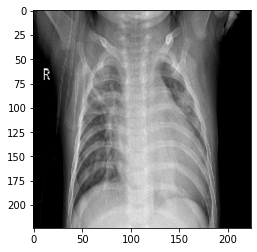

X-Ray file person21_virus_53.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person134_bacteria_644.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person128_bacteria_607.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person131_bacteria_629.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person137_bacteria_655.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person83_bacteria_412.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1642_virus_2842.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1622_virus_2810.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person141_bacteria_681.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person47_virus_99.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person120_bacteria_571.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file p

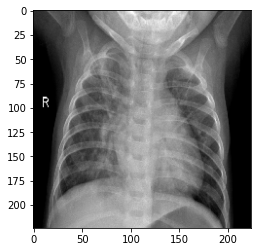

X-Ray file person146_bacteria_704.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person142_bacteria_684.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person158_bacteria_743.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person111_bacteria_535.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1669_virus_2884.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1_virus_6.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person61_virus_118.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person79_virus_148.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person8_virus_28.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1629_virus_2823.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1667_virus_2881.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person76_vir

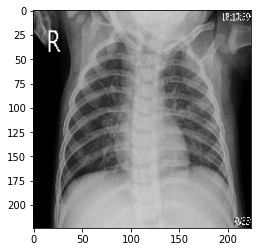

X-Ray file person109_bacteria_522.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person8_virus_27.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person100_bacteria_477.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person3_virus_15.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person17_virus_48.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person80_bacteria_393.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person93_bacteria_453.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person110_bacteria_531.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person25_virus_59.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person67_virus_126.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person140_bacteria_667.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person113_bacter

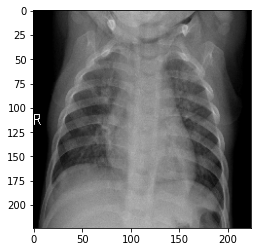

X-Ray file person93_bacteria_454.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person82_bacteria_402.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person96_bacteria_465.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person124_bacteria_591.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1632_virus_2827.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person161_bacteria_759.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person133_bacteria_638.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person36_virus_81.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person139_bacteria_661.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person109_bacteria_512.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1682_virus_2899.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray fil

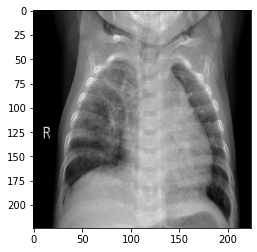

X-Ray file person1641_virus_2840.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1620_virus_2807.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person103_bacteria_489.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person46_virus_96.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person14_virus_44.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person155_bacteria_731.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person101_bacteria_483.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1678_virus_2895.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person141_bacteria_676.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person173_bacteria_831.jpeg Misclassified as a Normal X-Ray file. This is misclassified file 11 out of all 390 X-Ray files with Pneumonia


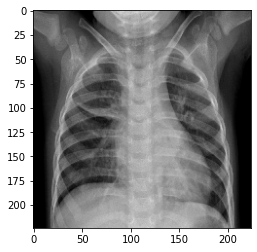

X-Ray file person95_bacteria_463.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person158_bacteria_742.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person81_bacteria_395.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person112_bacteria_539.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person122_bacteria_585.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person128_bacteria_608.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person157_bacteria_739.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person134_bacteria_642.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person175_bacteria_834.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person34_virus_76.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person74_virus_135.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file

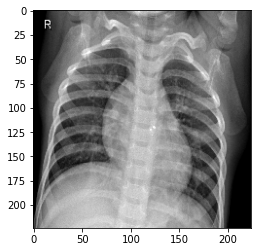

X-Ray file person91_bacteria_446.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person136_bacteria_654.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person1614_virus_2800.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person109_bacteria_519.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person111_bacteria_533.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person118_bacteria_560.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person23_virus_56.jpeg correctly classified as a X-Ray file with Pneumonia
X-Ray file person51_virus_105.jpeg correctly classified as a X-Ray file with Pneumonia
Accuracy for X-Ray files with Pneumonia in testing set:  0.9692307692307692


In [189]:
dir_path = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA'
arr = os.listdir(dir_path)
random.shuffle(arr)
count4 = 0
for i in arr:
    img = image.load_img(dir_path+'/'+i, target_size = (224,224))
    
    X = image.img_to_array(img)
    X = np.expand_dims(X,axis = 0)
    images = np.vstack([X])
    
    val = (ResNet18Img.predict(images) > 0.5).astype("int32")

    if val == 0:
        count4+=1
        print("X-Ray file", i, "Misclassified as a Normal X-Ray file. This is misclassified file", count4, "out of all", len(testPneumonia), "X-Ray files with Pneumonia", )
        if(count4 <= displayLimit):
            plt.imshow(img)
            plt.show()
    else:
        print("X-Ray file "+ i + " correctly classified as a X-Ray file with Pneumonia")
imgPneumoniaAccuracy = 1 - (count4 / len(testPneumonia))
print("Accuracy for X-Ray files with Pneumonia in testing set: ", imgPneumoniaAccuracy)

In [192]:
print("accuracy for test set: ", (imgNormalAccuracy + imgPneumoniaAccuracy) / 2 )

accuracy for test set:  0.7901709401709403


### Delete duplicate misclassified images predicted from both models from array. Display total number of misclassified images in testing set.

In [191]:
set(misclassifiedImgs)
print("Total misclassified X-Ray images from both models:", len(misclassifiedImgs), "out of", len(testNormal)+len(testPneumonia), "X-Ray images in the testing set" )

Total misclassified X-Ray images from both models: 195 out of 624 X-Ray images in the testing set


### Evaluate the ResNet-18 model with ImageNet initialized weights and parameters on the testing dataset.

In [193]:
ResNet18Img.evaluate(testing_dataset)

20/20 [==============================] - 8s 419ms/step - loss: 1.2698 - accuracy: 0.7804


[1.2698240280151367, 0.7804487347602844]

### Display randomly selected misclassified image. Obtain 18th convolutional layer of ResNet-50 model.

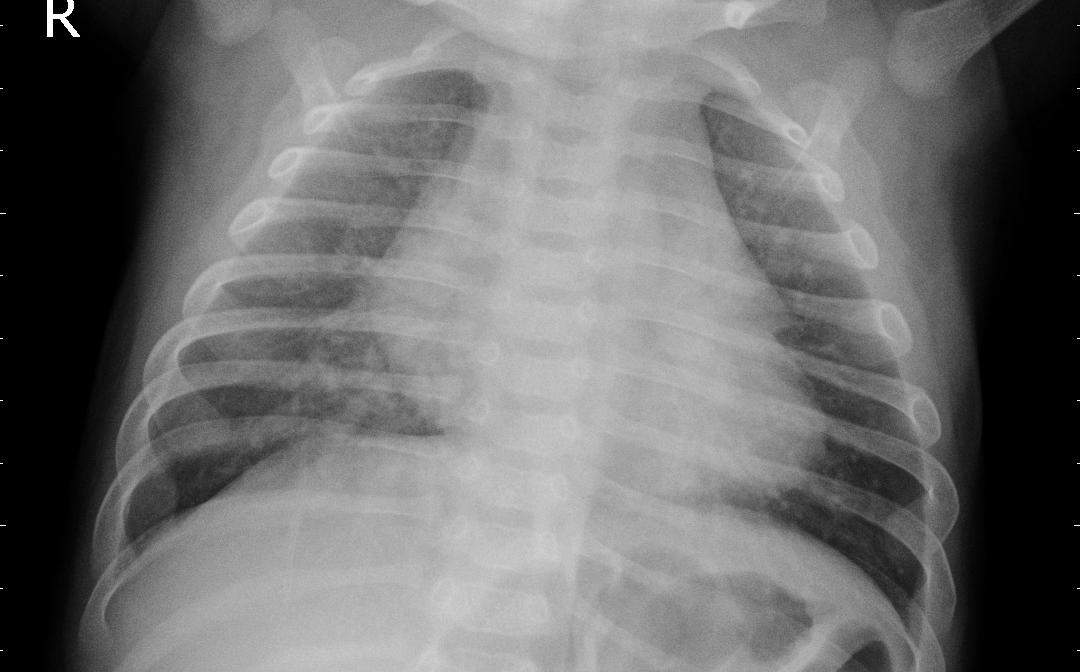

/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person1637_virus_2834.jpeg


In [217]:
from IPython.display import Image, display

img_size = (224, 224)
preprocess_input = tf.keras.applications.resnet50.preprocess_input
decode_predictions = tf.keras.applications.resnet50.decode_predictions

imgPath = random.choice(misclassifiedImgs)
misclassifiedImgs.remove(imgPath)
last_conv_layer_name = "conv3_block3_1_conv"
imgPath
display(Image(imgPath))
print(imgPath)

### Implement GRAD-CAM algorithm.

In [218]:
def get_img_array(imgPath, size):
    img = tf.keras.preprocessing.image.load_img(imgPath, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
   
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

### Generate class activation heatmap from outputs of convolutional layer.

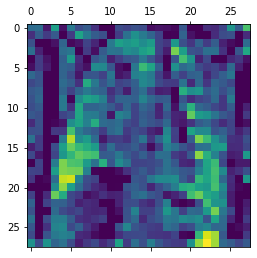

In [219]:
img_array = preprocess_input(get_img_array(imgPath, size=img_size))
model = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet')
model.layers[-1].activation = None

preds = model.predict(img_array)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.show()

### Superimpose heatmap onto misclassified image.

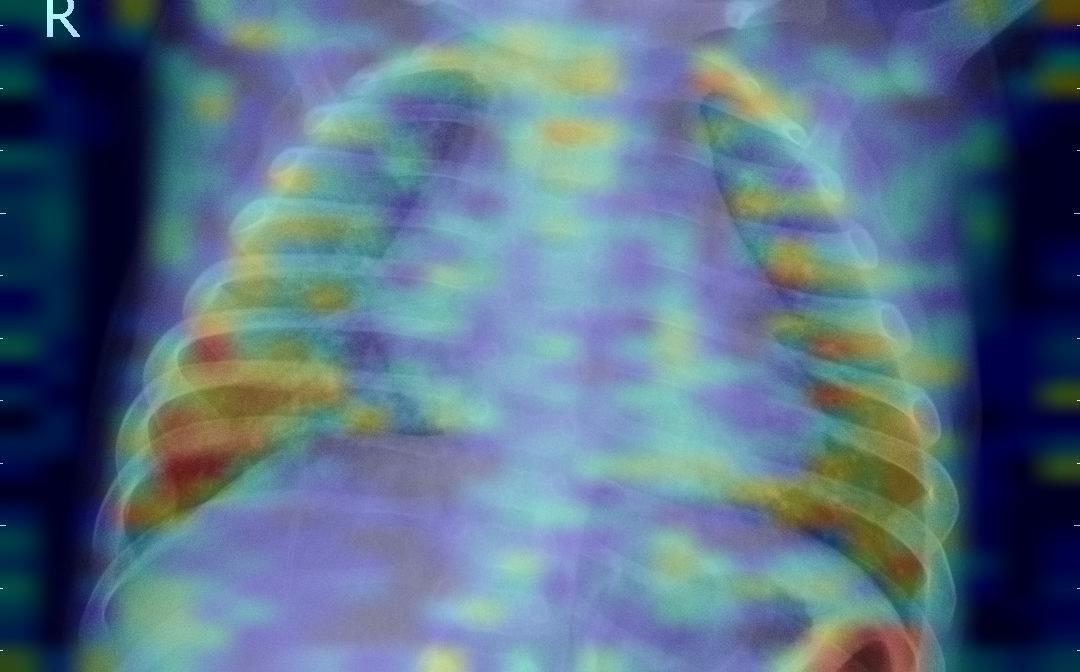

In [220]:
import matplotlib.cm as cm
def save_and_display_gradcam(imgPath, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(imgPath)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))

save_and_display_gradcam(imgPath, heatmap)

### Another example of Gradient Class Activation Map algorithm on misclassified image.

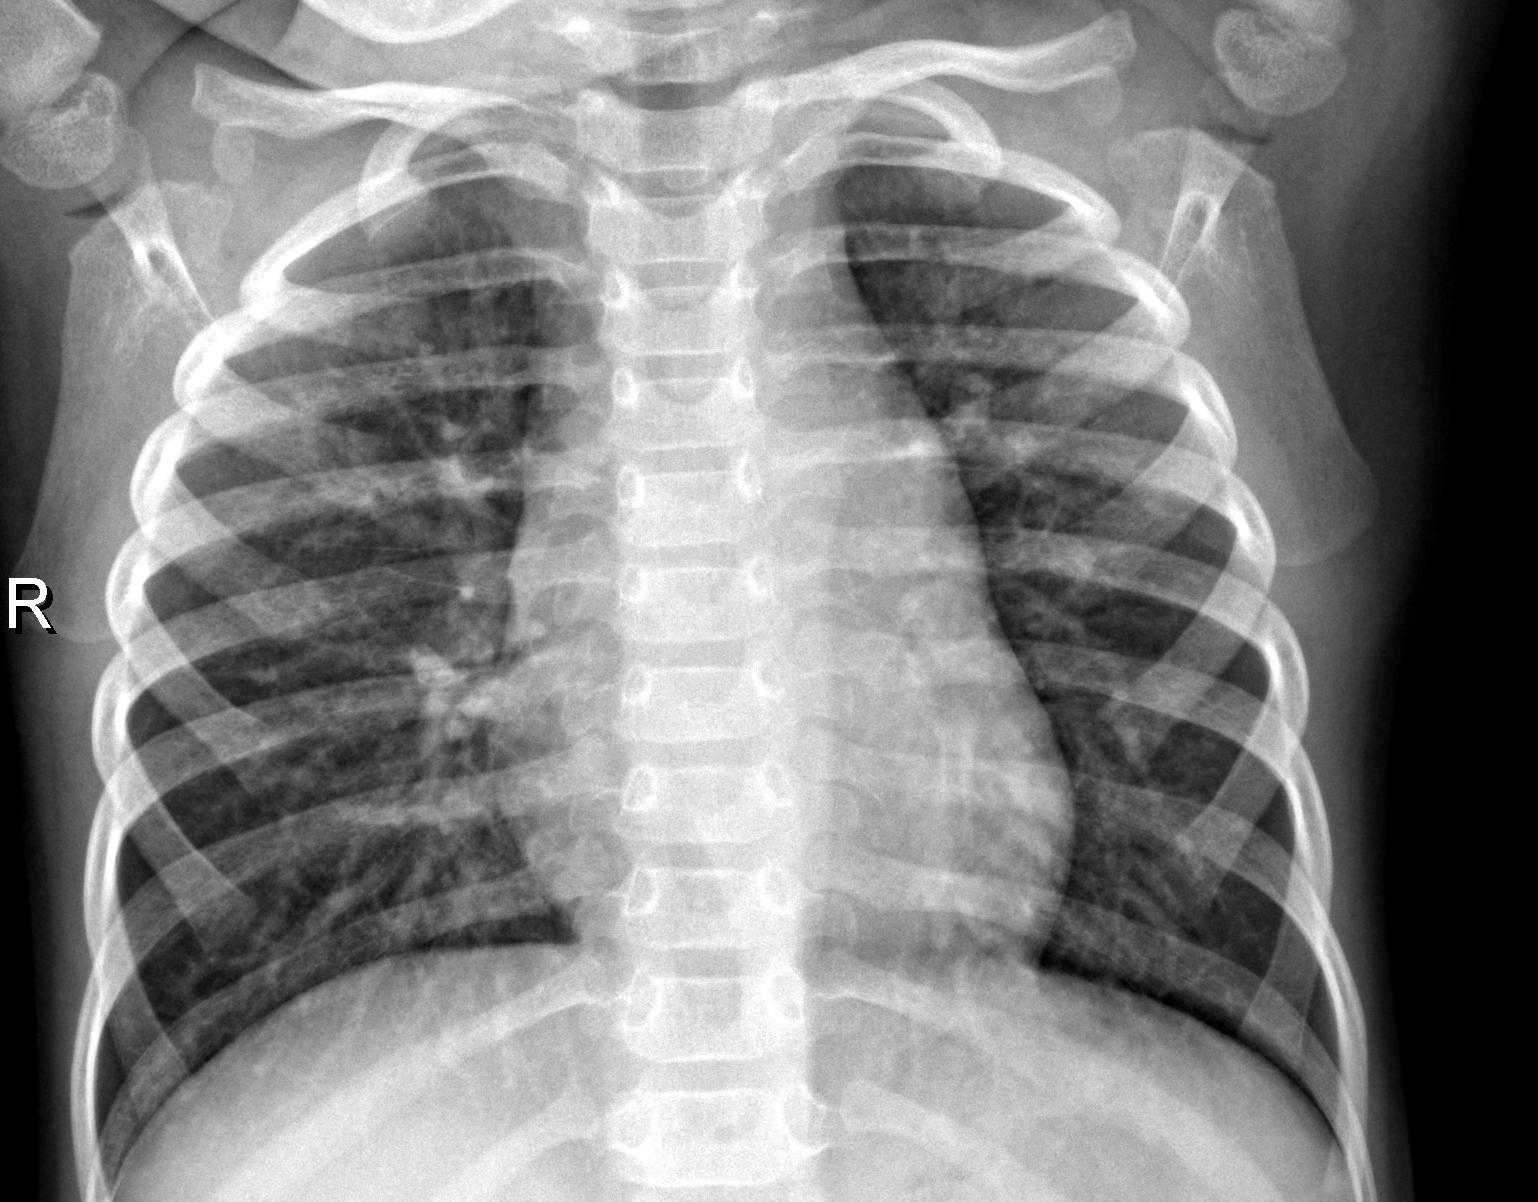

In [233]:
imgPath2 = random.choice(misclassifiedImgs)
misclassifiedImgs.remove(imgPath2)
display(Image(imgPath2))

img_array = preprocess_input(get_img_array(imgPath2, size=img_size))
preds = model.predict(img_array)

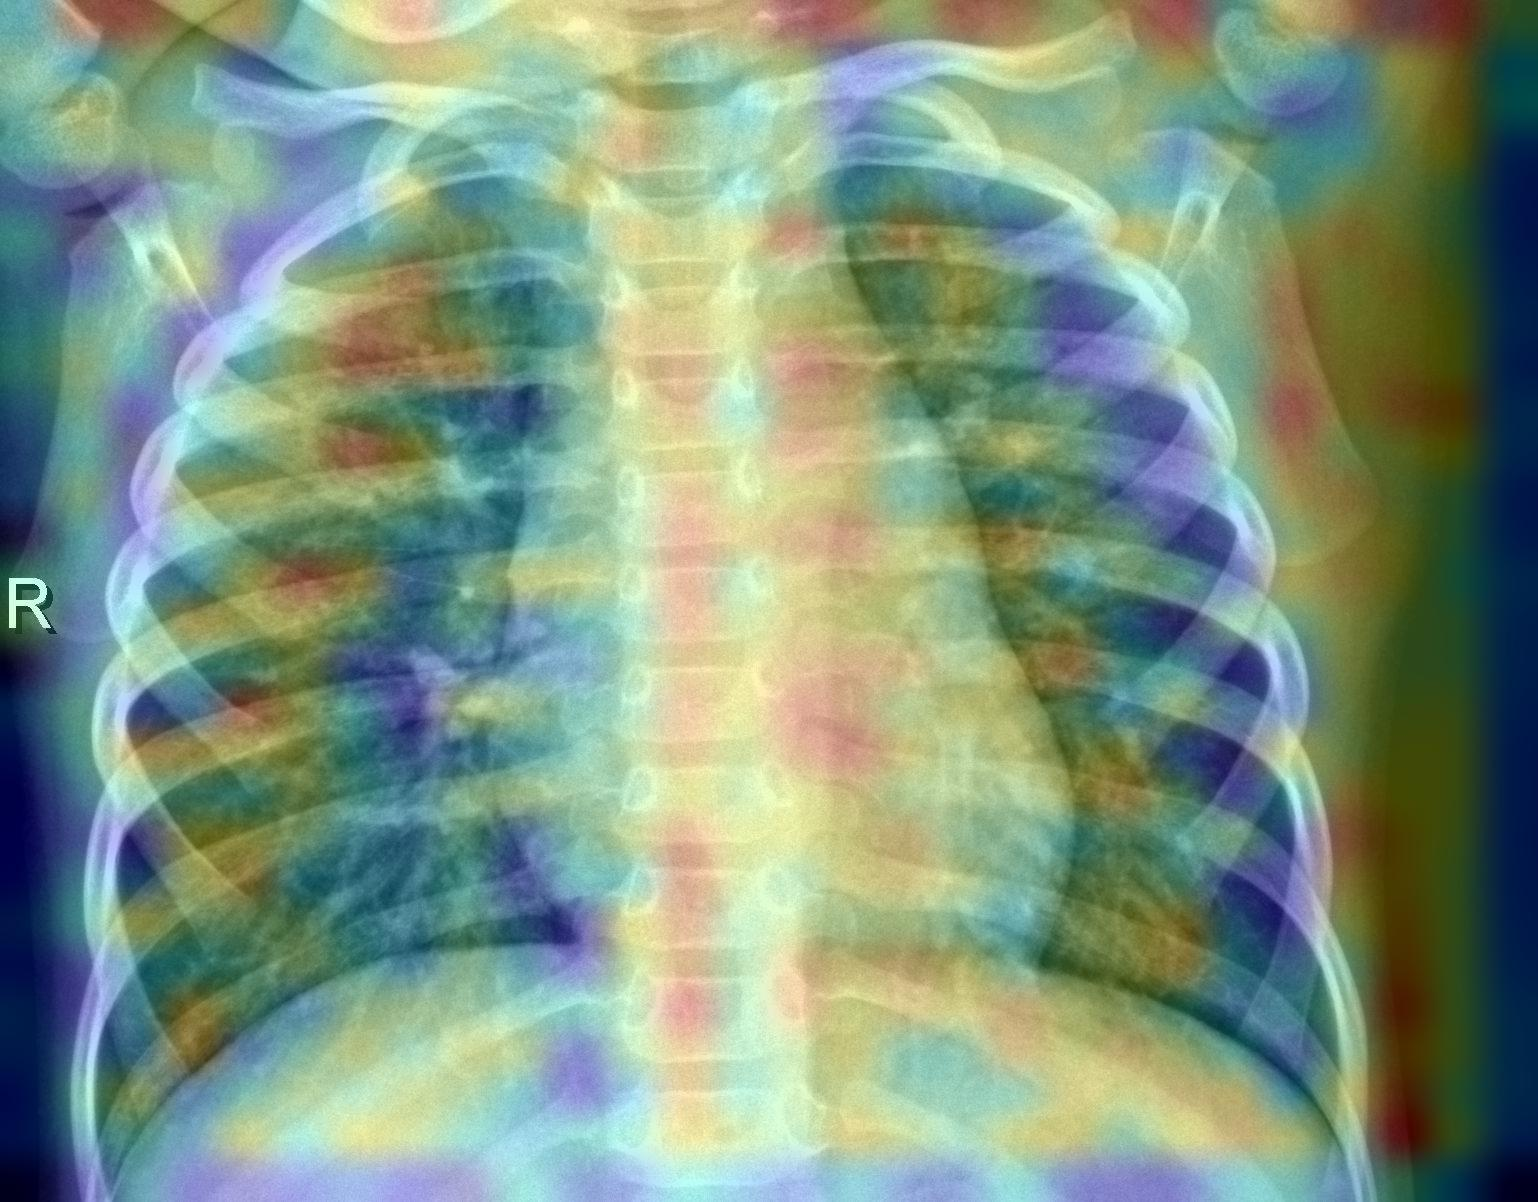

In [237]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(imgPath2, heatmap)